In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)

In [2]:
X = np.load('X_hcb.npy')
y = np.load('y_hcb.npy')

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [4]:
y_test.shape

(8702,)

## 4. Cost function

Since we have data preprocessed, we need to define financial score, describing profitability of our model.

In [5]:
def financial_score(y_true, y_pred):
    y_true = y_true.ravel().astype(int)
    y_pred = y_pred.ravel().astype(int)
    prediction_cost = y_pred.sum() * 100
    good_prediction_gain = (y_pred & y_true).sum() * 1000    
    return good_prediction_gain - prediction_cost

## 5. Examinig  baseline models
* Logistic Regression with default settings
* Logistic Regression with class weights

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report

In [7]:
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true=y_true,
                                     y_score=y_pred_proba)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    plt.scatter(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--')
    auc = roc_auc_score(y_true=y_true,
                        y_score=y_pred_proba)
    plt.title('AUC: {:.5f}'.format(auc))
    plt.show()

In [8]:
def get_best_threshold_for_F1(y_true, y_pred_prob, thresholds_number = 500):
    thresholds = np.linspace(start=0, stop=1, num=thresholds_number).tolist()
    f1_scores = []

    for t in thresholds:
        f1_scores.append(f1_score(y_true, (y_pred_prob>t)))

    scores_df = pd.DataFrame({'threshold': thresholds, 'F1': f1_scores})
    return scores_df[scores_df.F1 == scores_df.F1.max()]['threshold'].iloc[0]

In [9]:
def get_best_threshold_for_profit(y_true, y_pred_prob, thresholds_number = 500):
    thresholds = np.linspace(start=0, stop=1, num=thresholds_number).tolist()
    profit_scores = []

    for t in thresholds:
        profit_scores.append(financial_score(y_true, (y_pred_prob>t)))

    scores_df = pd.DataFrame({'threshold': thresholds, 'profit': profit_scores})
    return scores_df[scores_df.profit == scores_df.profit.max()]['threshold'].iloc[0]

#### Logistic Regression with default settings

In [10]:
model_bs = LogisticRegression()
model_bs.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set results:

In [11]:
y_pred_proba_train_bs = model_bs.predict_proba(X_train)[:, 1]

In [12]:
print(classification_report(y_train, (y_pred_proba_train_bs > 0.5)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     77172
         1.0       0.87      0.41      0.56      1146

    accuracy                           0.99     78318
   macro avg       0.93      0.71      0.78     78318
weighted avg       0.99      0.99      0.99     78318



Next, we can find optimal thresholds values from two perspectives - maximizing F1 score and maximizing profit.

In [13]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_bs)
f1 = f1_score(y_train, (y_pred_proba_train_bs > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5868 for threshold: 0.2104


In [14]:
threshold_profit = get_best_threshold_for_profit(y_train, y_pred_proba_train_bs)
profit = financial_score(y_train, (y_pred_proba_train_bs > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 514300 PLN for threshold: 0.0862


In [16]:
def plot_distributions_and_thresholds(y_pred_proba, 
                                      y_true, 
                                      threshold_profit, 
                                      threshold_f1, 
                                      title):
    plt.hist(y_pred_proba[y_true==0], label='0', bins=50, alpha=0.5)
    plt.hist(y_pred_proba[y_true==1], label='1', bins=50, alpha=0.5)
    plt.vlines(threshold_profit, 0, 100, color='green', linestyle='--',  label='max profit threshold')
    plt.vlines(threshold_f1, 0, 100, color='red', linestyle='--', label='max F1 threshold')
    plt.yscale('log')
    plt.legend()
    plt.title(title)

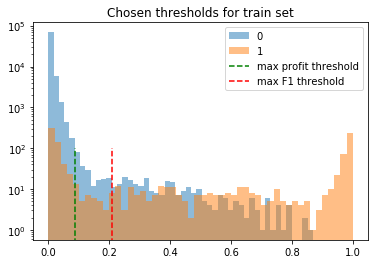

In [17]:
plot_distributions_and_thresholds(y_pred_proba_train_bs, 
                                  y_train, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for train set')

Test set results:

In [18]:
y_pred_proba_test_bs = model_bs.predict_proba(X_test)[:, 1]

In [19]:
print(classification_report(y_test, (y_pred_proba_test_bs > 0.5)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      8575
         1.0       0.85      0.44      0.58       127

    accuracy                           0.99      8702
   macro avg       0.92      0.72      0.79      8702
weighted avg       0.99      0.99      0.99      8702



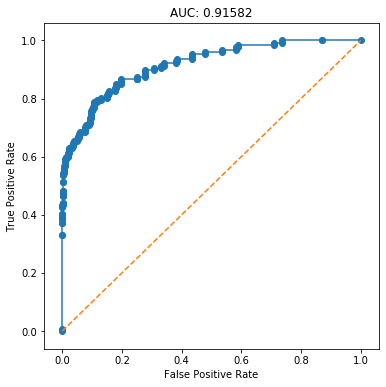

In [20]:
plot_roc_curve(y_test, y_pred_proba_test_bs)

In [21]:
f1 = f1_score(y_test, (y_pred_proba_test_bs > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.6018 for threshold: 0.2104


In [22]:
profit = financial_score(y_test, (y_pred_proba_test_bs > threshold_profit))
print('Test set profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Test set profit: 58400 PLN for threshold: 0.0862


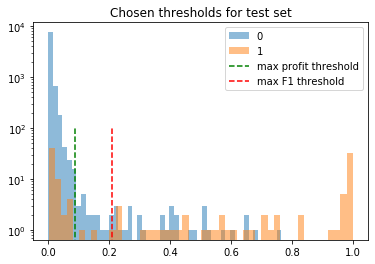

In [24]:
plot_distributions_and_thresholds(y_pred_proba_test_bs, 
                                  y_test, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for test set')

#### Logistic Regression with class weights

In [25]:
imbalance_ratio = len(np.where(y_train == 0)[0]) / len(np.where(y_train == 1)[0])

In [26]:
model_bs = LogisticRegression(class_weight={0: 1, 1: imbalance_ratio})
model_bs.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 67.34031413612566}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set results:

In [27]:
y_pred_proba_train_bs = model_bs.predict_proba(X_train)[:, 1]

In [28]:
print(classification_report(y_train, (y_pred_proba_train_bs > 0.5)))

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93     77172
         1.0       0.08      0.81      0.15      1146

    accuracy                           0.86     78318
   macro avg       0.54      0.84      0.54     78318
weighted avg       0.98      0.86      0.91     78318



In [29]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_bs)
f1 = f1_score(y_train, (y_pred_proba_train_bs > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5815 for threshold: 0.9719


In [30]:
threshold_profit = get_best_threshold_for_profit(y_train, y_pred_proba_train_bs)
profit = financial_score(y_train, (y_pred_proba_train_bs > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 512000 PLN for threshold: 0.9058


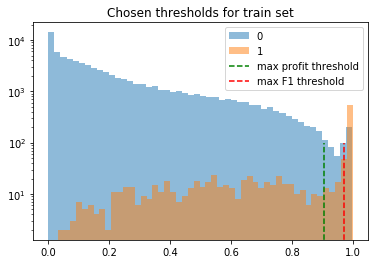

In [32]:
plot_distributions_and_thresholds(y_pred_proba_train_bs, 
                                  y_train, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for train set')

Test set results:

In [33]:
y_pred_proba_test_bs = model_bs.predict_proba(X_test)[:, 1]

In [34]:
print(classification_report(y_test, (y_pred_proba_test_bs > 0.5)))

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      8575
         1.0       0.08      0.79      0.15       127

    accuracy                           0.87      8702
   macro avg       0.54      0.83      0.54      8702
weighted avg       0.98      0.87      0.92      8702



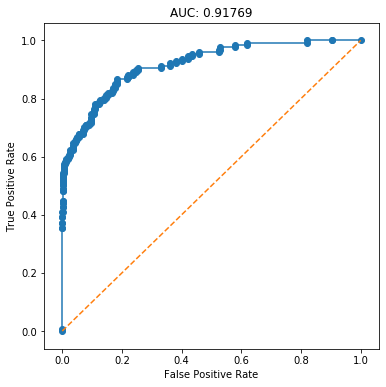

In [35]:
plot_roc_curve(y_test, y_pred_proba_test_bs)

In [36]:
f1 = f1_score(y_test, (y_pred_proba_test_bs > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Test set F1 score: 0.6147 for threshold: 0.9719


In [37]:
profit = financial_score(y_test, (y_pred_proba_test_bs > threshold_profit))
print('Test set profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Test set profit: 60000 PLN for threshold: 0.9058


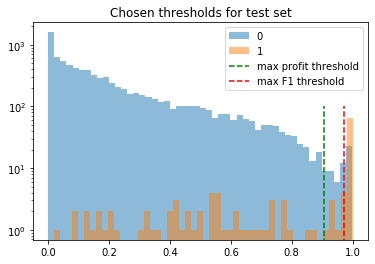

In [39]:
plot_distributions_and_thresholds(y_pred_proba_test_bs, 
                                  y_test, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for test set')

## 6. Exploring models with weighting classes techniques.

In [40]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold

In [41]:
models = [
    [('LogReg', LogisticRegression())],
    [('Bagging', BaggingClassifier(DecisionTreeClassifier(),
                                   max_samples=0.7,
                                   bootstrap=True))]
]

params_grid = [
     {'LogReg__C': [0.001, 0.01, 0.1, 1, 10, 100], 
     'LogReg__penalty': ['l1', 'l2'],
     'LogReg__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 40}, {0: 1, 1: 60}, {0: 1, 1: 80}]
    },
     {'Bagging__n_estimators': [200], 
      'Bagging__max_features': [10, 20],
      'Bagging__base_estimator__max_depth': [5, 10, 20, 40],
      'Bagging__base_estimator__min_samples_leaf': [5, 15, 20, 40],
      'Bagging__base_estimator__min_samples_split': [5, 15, 20, 40],
      'Bagging__base_estimator__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 40}, {0: 1, 1: 60}, {0: 1, 1: 80}]
     }
]

In [42]:
from sklearn.metrics import make_scorer

In [43]:
def financial_score_with_best_threshold(y_true, y_pred_proba):
    optimal_threshold = get_best_threshold_for_profit(y_true, y_pred_proba)
    profit = financial_score(y_true, (y_pred_proba > optimal_threshold))
    return profit

In [44]:
best_models = []
best_results = []
for pipe, params in zip(models, params_grid):
    pipeline = Pipeline(pipe)
    
    gs = GridSearchCV(estimator=pipeline,
                      param_grid=params,
                      cv=StratifiedKFold(10),
                      scoring=make_scorer(financial_score_with_best_threshold, needs_proba=True),
                      verbose=1,
                      n_jobs=-1)
    
    gs.fit(X_train, y_train)
    best_models.append(gs.best_estimator_)
    results = gs.cv_results_
    y_pred_proba = gs.best_estimator_.predict_proba(X_test)[:, 1]
    best_threshold = get_best_threshold_for_profit(y_test, y_pred_proba, thresholds_number=1000)

    results['test_set_financial_score'] = financial_score(y_test, (y_pred_proba>best_threshold))
    best_results.append(pd.DataFrame(results))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 169.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 220.7min finished


Fitting 10 folds for each of 512 candidates, totalling 5120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 105.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 173.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 229.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 326.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 420.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 540.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 674.6min
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed: 695.5min finished


In [45]:
best_models

[Pipeline(memory=None,
          steps=[('LogReg',
                  LogisticRegression(C=10, class_weight={0: 1, 1: 1}, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='warn', n_jobs=None,
                                     penalty='l1', random_state=None,
                                     solver='warn', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), Pipeline(memory=None,
          steps=[('Bagging',
                  BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 1,
                                                                                        1: 1},
                                                                          criterion='gini',
                                                                          max_depth=5,
     

In [69]:
best_results[1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Bagging__base_estimator__class_weight,param_Bagging__base_estimator__max_depth,param_Bagging__base_estimator__min_samples_leaf,param_Bagging__base_estimator__min_samples_split,param_Bagging__max_features,param_Bagging__n_estimators,...,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,test_set_financial_score
0,39.109182,1.467294,1.039998,0.163826,"{0: 1, 1: 1}",5,5,5,10,200,...,49600.0,49100.0,56200.0,52100.0,46600.0,41100.0,50620.218851,4839.989016,55,59700
1,65.332857,1.847301,1.873972,0.190201,"{0: 1, 1: 1}",5,5,5,20,200,...,59100.0,51500.0,56800.0,52200.0,46800.0,43100.0,52290.234684,4885.523173,5,59700
2,38.887982,1.296656,0.957509,0.075121,"{0: 1, 1: 1}",5,5,15,10,200,...,59400.0,49400.0,57900.0,50800.0,48100.0,41000.0,51620.194591,5377.809385,19,59700
3,64.991095,1.583236,1.865355,0.177216,"{0: 1, 1: 1}",5,5,15,20,200,...,59900.0,51300.0,57500.0,52300.0,47600.0,42400.0,52130.196123,4965.402839,13,59700
4,37.531238,0.944072,1.039709,0.175123,"{0: 1, 1: 1}",5,5,20,10,200,...,60200.0,51800.0,55700.0,50900.0,46200.0,44500.0,51620.195868,4615.751411,18,59700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,93.988595,1.195558,1.970140,0.148702,"{0: 1, 1: 80}",40,40,15,20,200,...,13800.0,17100.0,21400.0,21600.0,15200.0,15500.0,18210.092188,4468.529896,324,59700
508,48.608417,1.426280,1.111916,0.129600,"{0: 1, 1: 80}",40,40,20,10,200,...,14600.0,11800.0,10000.0,8100.0,6300.0,11100.0,9700.089379,3823.746968,485,59700
509,94.140000,1.319409,2.035762,0.112486,"{0: 1, 1: 80}",40,40,20,20,200,...,15700.0,22700.0,18800.0,14200.0,14700.0,13300.0,17270.239281,5354.073519,337,59700
510,49.424471,1.520018,1.095896,0.059126,"{0: 1, 1: 80}",40,40,40,10,200,...,14000.0,8800.0,11500.0,6100.0,7500.0,8400.0,9510.111341,3076.906838,488,59700


In [70]:
best_models[1][0].get_params()

{'base_estimator__class_weight': {0: 1, 1: 1},
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 5,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 15,
 'base_estimator__min_samples_split': 40,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight={0: 1, 1: 1}, criterion='gini', max_depth=5,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=15, min_samples_split=40,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'bootstrap': True,
 'bootstr

#### Best LogisticRegression model

In [87]:
lr_params = best_models[0][0].get_params()

In [89]:
best_gs_model = LogisticRegression(**lr_params)
best_gs_model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Train set results

In [90]:
y_pred_proba_train_gs = best_gs_model.predict_proba(X_train)[:, 1]

In [91]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_gs)
f1 = f1_score(y_train, (y_pred_proba_train_gs > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5880 for threshold: 0.3166


In [92]:
threshold_profit = get_best_threshold_for_profit(y_train, y_pred_proba_train_gs)
profit = financial_score(y_train, (y_pred_proba_train_gs > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 517900 PLN for threshold: 0.1222


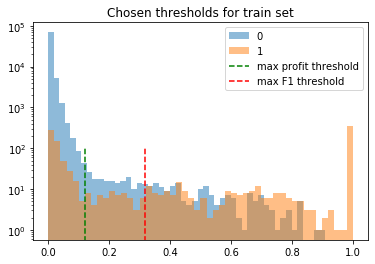

In [93]:
plot_distributions_and_thresholds(y_pred_proba_train_gs, 
                                  y_train, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for train set')

Test set results

In [94]:
y_pred_proba_test_gs = best_gs_model.predict_proba(X_test)[:, 1]

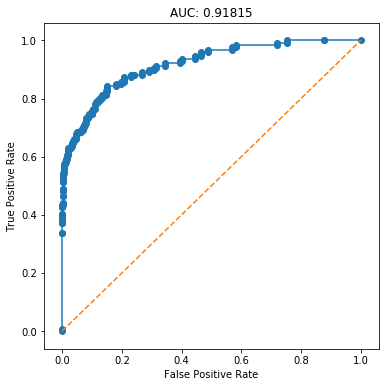

In [95]:
plot_roc_curve(y_test, y_pred_proba_test_gs)

In [96]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_gs)
f1 = f1_score(y_test, (y_pred_proba_test_gs > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6119 for threshold: 0.2605


In [97]:
threshold_profit = get_best_threshold_for_profit(y_test, y_pred_proba_test_gs)
profit = financial_score(y_test, (y_pred_proba_test_gs > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 59700 PLN for threshold: 0.1142


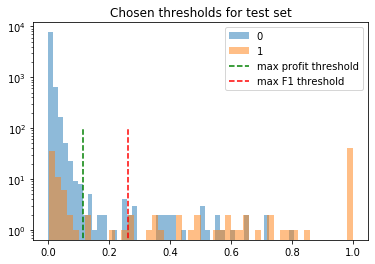

In [98]:
plot_distributions_and_thresholds(y_pred_proba_test_gs, 
                                  y_test, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for test set')

#### Best BaggingClasifier model

In [74]:
bc_params = best_models[1][0].get_params()
best_gs_model = BaggingClassifier(base_estimator=bc_params['base_estimator'],
                 max_features=bc_params['max_features'],
                 n_estimators=bc_params['n_estimators'])
best_gs_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 1,
                                                                      1: 1},
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=15,
                                                        min_samples_split=40,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
 

Train set results

In [75]:
y_pred_proba_train_gs = best_gs_model.predict_proba(X_train)[:, 1]

In [76]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_gs)
f1 = f1_score(y_train, (y_pred_proba_train_gs > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5998 for threshold: 0.0942


In [77]:
threshold_profit = get_best_threshold_for_profit(y_train, y_pred_proba_train_gs)
profit = financial_score(y_train, (y_pred_proba_train_gs > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 529900 PLN for threshold: 0.0521


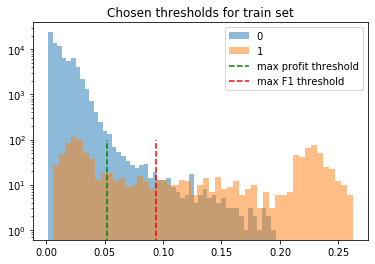

In [78]:
plot_distributions_and_thresholds(y_pred_proba_train_gs, 
                                  y_train, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for train set')

Test set results

In [79]:
y_pred_proba_test_gs = best_gs_model.predict_proba(X_test)[:, 1]

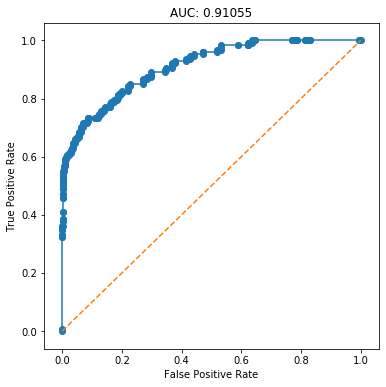

In [80]:
plot_roc_curve(y_test, y_pred_proba_test_gs)

In [81]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_gs)
f1 = f1_score(y_test, (y_pred_proba_test_gs > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6140 for threshold: 0.0842


In [82]:
threshold_profit = get_best_threshold_for_profit(y_test, y_pred_proba_test_gs)
profit = financial_score(y_test, (y_pred_proba_test_gs > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 59900 PLN for threshold: 0.0501


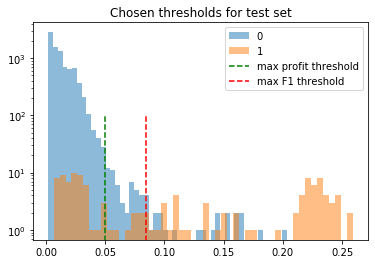

In [84]:
plot_distributions_and_thresholds(y_pred_proba_test_gs, 
                                  y_test, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for test set')

## 7. Cross validation undersampling

In [49]:
from copy import deepcopy

def cv_repeated_undersampling(X, 
                              y, 
                              model, 
                              size=1, 
                              n_estimators=20, 
                              cv=StratifiedKFold(5)):
    
    y_pred_proba = []
    y_true = []
    
    for train_idx, test_idx in cv.split(X, y):
        
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        y_train, y_test = y[train_idx], y[test_idx]
        
        class_0_indexes = np.where(y_train==0)[0]
        class_1_amount = np.sum((y_train==1).astype(int))
        class_0_indexes_number = int(size * class_1_amount)
        
        y_pred_proba_cv = np.zeros((n_estimators, len(y_test)))
        
        for i in range(n_estimators):
        
            idx0 = np.random.choice(class_0_indexes, class_0_indexes_number, replace=False)
            idx1 = np.where(y_train==1)[0]
            idx_all = np.r_[idx0, idx1]

            X_train_sub = X_train[idx_all, :]
            y_train_sub = y_train[idx_all]

            model_tmp = deepcopy(model)
            model_tmp.fit(X_train_sub, y_train_sub)
            y_prob = model_tmp.predict_proba(X_test)[:, 1]
            y_pred_proba_cv[i,:] = y_prob
        
        y_pred_proba_cv_mean = y_pred_proba_cv.mean(0)
        
        y_pred_proba.extend(y_pred_proba_cv_mean.tolist())
        y_true.extend(y_test.tolist())
        
    return np.array(y_pred_proba), np.array(y_true)

In [50]:
def predict_with_repeated_undersampling(X_train, 
                                        y_train, 
                                        X_test, 
                                        model, 
                                        size=1, 
                                        n_estimators=20):    
        
    y_pred_proba_matrix = np.zeros((n_estimators, X_test.shape[0]))

    for i in range(n_estimators):
        class_0_indexes = np.where(y_train==0)[0]
        class_1_amount = np.sum((y_train==1).astype(int))
        class_0_indexes_number = int(size * class_1_amount)

        idx0 = np.random.choice(class_0_indexes, class_0_indexes_number, replace=False)
        idx1 = np.where(y_train==1)[0]
        idx_all = np.r_[idx0, idx1]

        X_train_sub = X_train[idx_all, :]
        y_train_sub = y_train[idx_all]

        model_tmp = deepcopy(model)
        model_tmp.fit(X_train_sub, y_train_sub)
        y_prob = model_tmp.predict_proba(X_test)[:, 1]
        y_pred_proba_matrix[i,:] = y_prob

    y_pred_proba_mean = y_pred_proba_matrix.mean(0)
        
    return y_pred_proba_mean

In [63]:
from sklearn.model_selection import ParameterGrid

### 7.1. First iteration of undersampling grid search

In [64]:
hyperparams = [
    {
       'model': LogisticRegression(),
        'grid': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100], 
            'penalty': ['l1', 'l2']
         }
    },
    {
        'model': RandomForestClassifier(),
        'grid': {
            'n_estimators': [200], 
            'max_features': [10, 20],
            'max_depth': [10, 20, 40],
            'min_samples_leaf': [15, 20, 40],
            'min_samples_split': [15, 20, 40]
         }
    }
]

In [129]:
def undersampling_grid_search(hyperparams):
    best_f1_score_models = []
    best_profit_models = []
    best_auc_models = []

    for params in hyperparams:
        pg = ParameterGrid(params['grid'])
        models = []
        f1_scores = []
        profits = []
        auc_scores = []
        print('model: {}'.format(params['model'].__class__.__name__))
        for idx, combination in enumerate(pg):
            
            model = params['model']
            model.set_params(**combination)
            y_pred_proba_cv_us, y_cv = cv_repeated_undersampling(X=X_train, 
                                                                 y=y_train, 
                                                                 model=model,
                                                                 n_estimators=100, 
                                                                 size=2, 
                                                                 cv=StratifiedKFold(10))
            y_pred_proba_test_us = predict_with_repeated_undersampling(X_train, 
                                                                       y_train, 
                                                                       X_test, 
                                                                       model=model, 
                                                                       n_estimators=100, 
                                                                       size=2)

            threshold_f1 = get_best_threshold_for_F1(y_cv, y_pred_proba_cv_us)
            threshold_profit = get_best_threshold_for_profit(y_cv, y_pred_proba_cv_us)

            f1_scores.append(f1_score(y_test, (y_pred_proba_test_us > threshold_f1)))
            profits.append(financial_score(y_test, (y_pred_proba_test_us > threshold_profit)))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba_test_us))

            models.append(model)

        best_f1_score_model_idx = np.argmax(np.array(f1_scores))
        best_profit_model_idx = np.argmax(np.array(profits))
        best_auc_model_idx = np.argmax(np.array(auc_scores))

        best_f1_score_models.append({
            'model': models[best_f1_score_model_idx],
            'F1': f1_scores[best_f1_score_model_idx],
            'profit': profits[best_f1_score_model_idx],
            'AUC': auc_scores[best_f1_score_model_idx]
        })
        best_profit_models.append({
            'model': models[best_profit_model_idx],
            'F1': f1_scores[best_profit_model_idx],
            'profit': profits[best_profit_model_idx],
            'AUC': auc_scores[best_profit_model_idx]
        })
        best_auc_models.append({
            'model': models[best_auc_model_idx],
            'F1': f1_scores[best_auc_model_idx],
            'profit': profits[best_auc_model_idx],
            'AUC': auc_scores[best_auc_model_idx]
        })
    return best_f1_score_models, best_profit_models, best_auc_models

In [ ]:
best_f1_score_models, best_profit_models, best_auc_models = undersampling_grid_search(hyperparams)

In [131]:
best_profit_models

[{'model': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  'F1': 0.5991189427312776,
  'profit': 60700,
  'AUC': 0.9179568880420559},
 {'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=40, max_features=20, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=40, min_samples_split=40,
                         min_weight_fraction_leaf=0.0, n_estimators=200,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False),
  'F1': 0.5898617511520737,
  'profit': 56900,
  'AUC': 0.914230619

Chosen hiperparameter values lie on boundaires of given space, therefore hiperparameters space should be broaden durning next iterarion. Nevertheless, best models and their performance are shown below.

#### Best LogisticRegression model for profit

In [132]:
us_params = best_profit_models[0]['model'].get_params()
us_params

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [135]:
best_us_model = LogisticRegression(**us_params)

Train set results

In [137]:
y_pred_proba_train_us = predict_with_repeated_undersampling(X_train, 
                                                            y_train, 
                                                            X_train, 
                                                            model=best_us_model,
                                                            n_estimators=100,
                                                            size=2)

In [138]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_us)
f1 = f1_score(y_train, (y_pred_proba_train_us > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5830 for threshold: 0.9218


In [139]:
threshold_profit = get_best_threshold_for_profit(y_train, y_pred_proba_train_us)
profit = financial_score(y_train, (y_pred_proba_train_us > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 516500 PLN for threshold: 0.8357


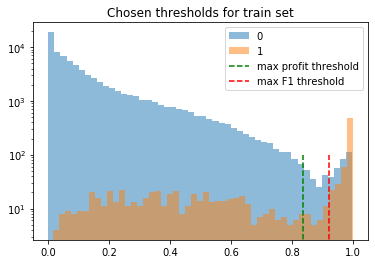

In [140]:
plot_distributions_and_thresholds(y_pred_proba_train_us, 
                                  y_train, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for train set')

Test set results

In [141]:
y_pred_proba_test_us = predict_with_repeated_undersampling(X_train, 
                                                           y_train, 
                                                           X_test,
                                                           model=best_us_model,
                                                           n_estimators=100,
                                                           size=2)

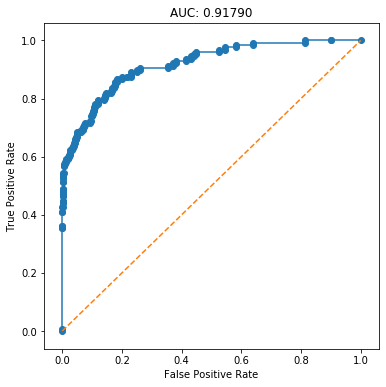

In [142]:
plot_roc_curve(y_test, y_pred_proba_test_us)

In [143]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_us)
f1 = f1_score(y_test, (y_pred_proba_test_us > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6154 for threshold: 0.9359


In [144]:
threshold_profit = get_best_threshold_for_profit(y_test, y_pred_proba_test_us)
profit = financial_score(y_test, (y_pred_proba_test_us > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 61000 PLN for threshold: 0.8377


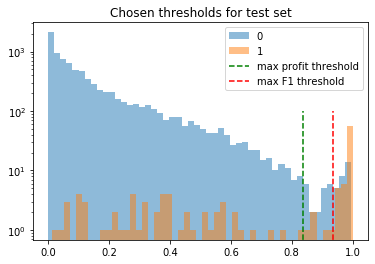

In [145]:
plot_distributions_and_thresholds(y_pred_proba_test_us, 
                                  y_test, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for test set')

#### Best RandomForestClassifier model for profit

In [146]:
us_params = best_profit_models[1]['model'].get_params()
us_params

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 20,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 40,
 'min_samples_split': 40,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [147]:
best_us_model = RandomForestClassifier(**us_params)

Train set results

In [149]:
y_pred_proba_train_us = predict_with_repeated_undersampling(X_train, 
                                                            y_train, 
                                                            X_train,
                                                            model=best_us_model,
                                                            n_estimators=100,
                                                            size=2)

In [150]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_us)
f1 = f1_score(y_train, (y_pred_proba_train_us > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5287 for threshold: 0.6874


In [151]:
threshold_profit = get_best_threshold_for_profit(y_train, y_pred_proba_train_us)
profit = financial_score(y_train, (y_pred_proba_train_us > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 441200 PLN for threshold: 0.5691


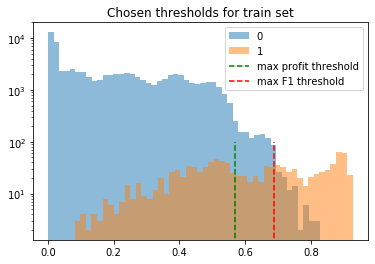

In [152]:
plot_distributions_and_thresholds(y_pred_proba_train_us, 
                                  y_train, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for train set')

Test set results

In [153]:
y_pred_proba_test_us = predict_with_repeated_undersampling(X_train, 
                                                           y_train, 
                                                           X_test,
                                                           model=best_us_model,
                                                           n_estimators=100,
                                                           size=2)

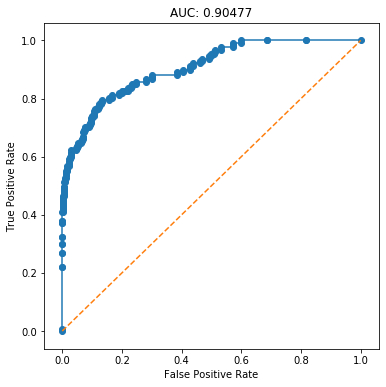

In [154]:
plot_roc_curve(y_test, y_pred_proba_test_us)

In [155]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_us)
f1 = f1_score(y_test, (y_pred_proba_test_us > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5622 for threshold: 0.7054


In [156]:
threshold_profit = get_best_threshold_for_profit(y_test, y_pred_proba_test_us)
profit = financial_score(y_test, (y_pred_proba_test_us > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 52200 PLN for threshold: 0.6132


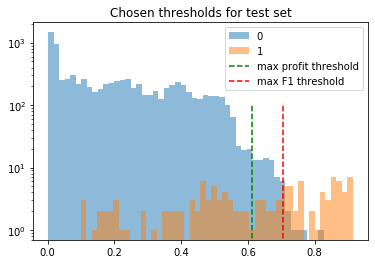

In [157]:
plot_distributions_and_thresholds(y_pred_proba_test_us, 
                                  y_test, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for test set')

### 7.2. Second iteration of undersampling grid search

In [158]:
hyperparams = [
    {
       'model': LogisticRegression(),
        'grid': {
            'C': [10, 100, 150, 200, 300], 
            'penalty': ['l1', 'l2']
         }
    },
    {
        'model': RandomForestClassifier(),
        'grid': {
            'n_estimators': [200], 
            'max_features': [20],
            'max_depth': [30, 40, 50, 70, 100],
            'min_samples_leaf': [30, 40, 50, 100],
            'min_samples_split': [30, 40, 50, 100]
         }
    }
]

In [159]:
best_f1_score_models, best_profit_models, best_auc_models = undersampling_grid_search(hyperparams)

model: LogisticRegression
model: RandomForestClassifier


In [160]:
best_profit_models

[{'model': LogisticRegression(C=300, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  'F1': 0.593886462882096,
  'profit': 60700,
  'AUC': 0.917026698193338},
 {'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=100, max_features=20, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=100, min_samples_split=100,
                         min_weight_fraction_leaf=0.0, n_estimators=200,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False),
  'F1': 0.5742574257425743,
  'profit': 53000,
  'AUC': 0.90848511

#### Best LogisticRegression model for profit

In [161]:
us_params = best_profit_models[0]['model'].get_params()
us_params

{'C': 300,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [162]:
best_us_model = LogisticRegression(**us_params)

Train set results

In [163]:
y_pred_proba_train_us = predict_with_repeated_undersampling(X_train, 
                                                            y_train, 
                                                            X_train,
                                                            model=best_us_model,
                                                            n_estimators=100,
                                                            size=2)

In [164]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_us)
f1 = f1_score(y_train, (y_pred_proba_train_us > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.5841 for threshold: 0.9238


In [165]:
threshold_profit = get_best_threshold_for_profit(y_train, y_pred_proba_train_us)
profit = financial_score(y_train, (y_pred_proba_train_us > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 516400 PLN for threshold: 0.8277


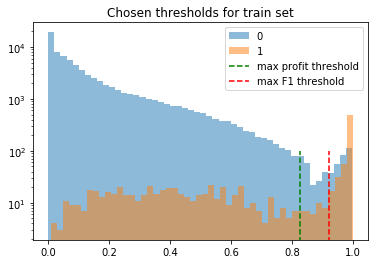

In [166]:
plot_distributions_and_thresholds(y_pred_proba_train_us, 
                                  y_train, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for train set')

Test set results

In [167]:
y_pred_proba_test_us = predict_with_repeated_undersampling(X_train, 
                                                           y_train, 
                                                           X_test,
                                                           model=best_us_model,
                                                           n_estimators=100,
                                                           size=2)

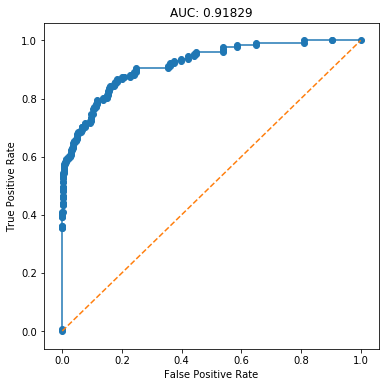

In [168]:
plot_roc_curve(y_test, y_pred_proba_test_us)

In [169]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_us)
f1 = f1_score(y_test, (y_pred_proba_test_us > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.6147 for threshold: 0.9399


In [170]:
threshold_profit = get_best_threshold_for_profit(y_test, y_pred_proba_test_us)
profit = financial_score(y_test, (y_pred_proba_test_us > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 61100 PLN for threshold: 0.8317


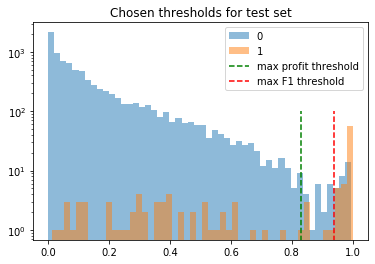

In [171]:
plot_distributions_and_thresholds(y_pred_proba_test_us, 
                                  y_test, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for test set')

#### Best RandomForestClassifier model for profit

In [172]:
us_params = best_profit_models[1]['model'].get_params()
us_params

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 100,
 'max_features': 20,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 100,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [173]:
best_us_model = RandomForestClassifier(**us_params)

Train set results

In [174]:
y_pred_proba_train_us = predict_with_repeated_undersampling(X_train, 
                                                            y_train, 
                                                            X_train,
                                                            model=best_us_model,
                                                            n_estimators=100,
                                                            size=2)

In [175]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_us)
f1 = f1_score(y_train, (y_pred_proba_train_us > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.3795 for threshold: 0.6593


In [176]:
threshold_profit = get_best_threshold_for_profit(y_train, y_pred_proba_train_us)
profit = financial_score(y_train, (y_pred_proba_train_us > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 272600 PLN for threshold: 0.6273


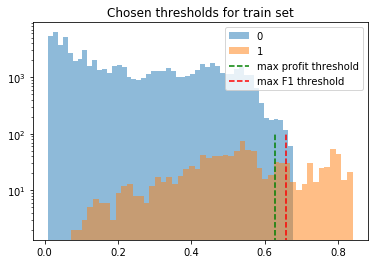

In [177]:
plot_distributions_and_thresholds(y_pred_proba_train_us, 
                                  y_train, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for train set')

Test set results

In [178]:
y_pred_proba_test_us = predict_with_repeated_undersampling(X_train, 
                                                           y_train, 
                                                           X_test,
                                                           model=best_us_model,
                                                           n_estimators=100,
                                                           size=2)

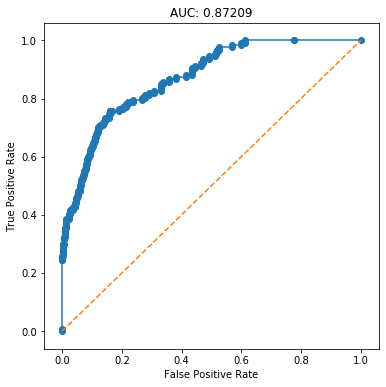

In [179]:
plot_roc_curve(y_test, y_pred_proba_test_us)

In [180]:
threshold_f1 = get_best_threshold_for_F1(y_test, y_pred_proba_test_us)
f1 = f1_score(y_test, (y_pred_proba_test_us > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

Max F1 score: 0.4023 for threshold: 0.6573


In [181]:
threshold_profit = get_best_threshold_for_profit(y_test, y_pred_proba_test_us)
profit = financial_score(y_test, (y_pred_proba_test_us > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max profit: 32800 PLN for threshold: 0.5932


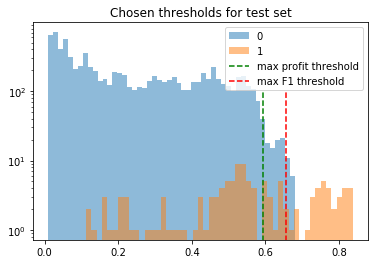

In [182]:
plot_distributions_and_thresholds(y_pred_proba_test_us, 
                                  y_test, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for test set')